In [22]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import time
%matplotlib inline
import sys
sys.path.append('./')

# from intersections_and_roads import *
from final_project import *
# from search import *
from shapely.geometry import *
import ast

**Cambridge Graph**

In [23]:
cambridge_map = map_structure(city='Cambridge')

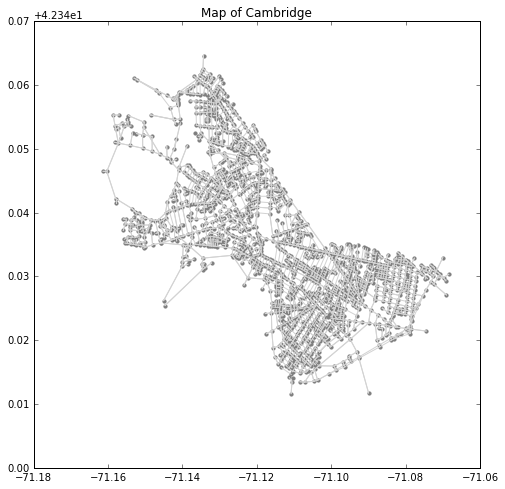

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph(ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

**San Francisco**

In [9]:
san_fran_map = map_structure(city='San Francisco')

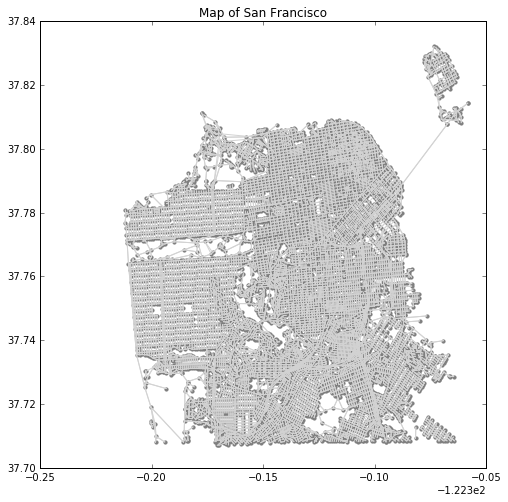

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph(ax=ax)
ax.set_title('Map of San Francisco')
plt.show()

### Section 1: Graph Search - A*

In [6]:
# randomly select a start and an end point on the graph for test
intersection_graph = san_fran_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

In [7]:
# search the graph
route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_road_cost,
                                   heuristic=san_fran_map.null_heuristic)
safe_route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_safe_road_cost,
                                   heuristic=san_fran_map.null_heuristic)

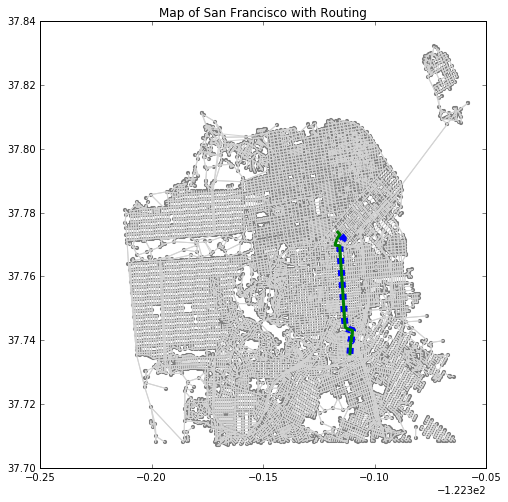

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph([route['nodes']], [safe_route['nodes']], ax=ax)
ax.set_title('Map of San Francisco with Routing')
plt.show()

**Lets collect some data:**

In [53]:
def sim(start, end, cost_fn, heuristic_fn, map_to_test):
    route, nodes_expanded = map_to_test.a_star_search(start,
                                   end,
                                   road_cost=cost_fn,
                                   heuristic=heuristic_fn,
                                   return_expanded_nodes = True)
    
    solution_distance = map_to_test.get_road_cost(route['nodes'], route['connections'])
    delta_elev = np.sum([map_to_test.road_connections[conn].delta_elevation for conn in route['connections']])
    return (route['nodes'], solution_distance, delta_elev, len(nodes_expanded))

def execute_simulation(nsims, cost_fn, heuristic_fn, map_to_test=san_fran_map):
    euclidean_dist = []
    solution_nodes = [[],[],[]]
    solution_route_distance = [[],[],[]]
    solution_delta_elevation = [[],[],[]]
    solution_nodes_expanded = [[],[],[]]

    for i in range(nsims):
        try:
            start = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
            end = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
            euclid_dist = 0
            while (end.id == start.id) or ((euclid_dist < 0.05) or (euclid_dist > 0.15)):
                end = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
                euclid_dist = euclidean_distance(start.get_x_y(), end.get_x_y())

            euclidean_dist.append(euclid_dist)
            # under the null heuristic
            k = 0
            result = sim(start, end, cost_fn[0], heuristic_fn[0], map_to_test)
            solution_nodes[k].append(result[0])
            solution_route_distance[k].append(result[1])
            solution_delta_elevation[k].append(result[2])
            solution_nodes_expanded[k].append(result[3])

            # under the euclidean_heuristic heuristic
            k = 1
            result = sim(start, end, cost_fn[1], heuristic_fn[1], map_to_test)
            solution_nodes[k].append(result[0])
            solution_route_distance[k].append(result[1])
            solution_delta_elevation[k].append(result[2])
            solution_nodes_expanded[k].append(result[3])

            k = 2
            # under the combined_heuristic heuristic
            result = sim(start, end, cost_fn[2], heuristic_fn[2], map_to_test)
            solution_nodes[k].append(result[0])
            solution_route_distance[k].append(result[1])
            solution_delta_elevation[k].append(result[2])
            solution_nodes_expanded[k].append(result[3])
        except:
            print start, end
        
    return euclidean_dist, solution_nodes, solution_route_distance, solution_delta_elevation, solution_nodes_expanded

#watch out for this number. The larger it is the longer this will all take!!! (100 is MASSIVE)
nsim = 100

### Basic road cost

In [26]:
# Cost function = get_road_cost ## I.e. simple road cost
cost_fn = [san_fran_map.get_road_cost, san_fran_map.get_road_cost, san_fran_map.get_road_cost]
heuristic = [san_fran_map.null_heuristic, san_fran_map.euclidean_heuristic, san_fran_map.combined_heuristic]

result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

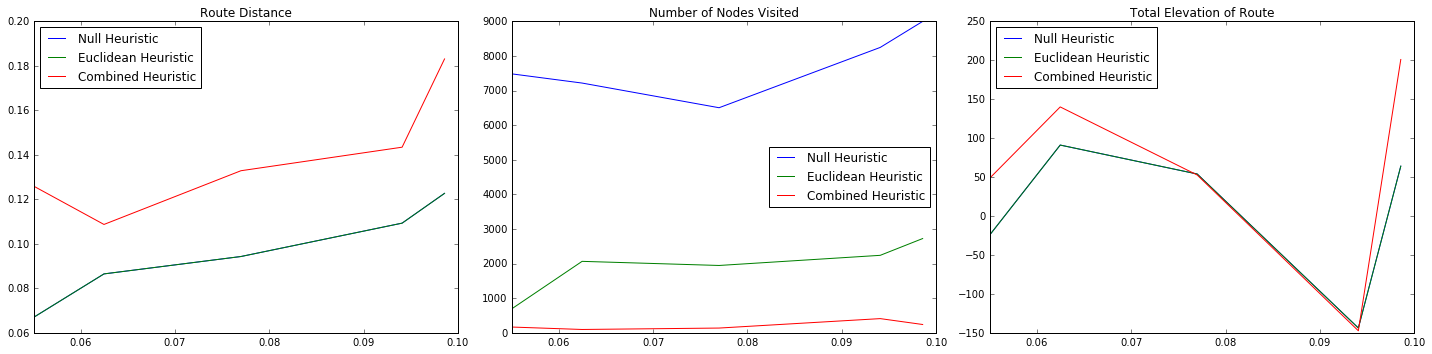

In [27]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

### Safe Road Cost

In [28]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
cost_fn = [san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost]
result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

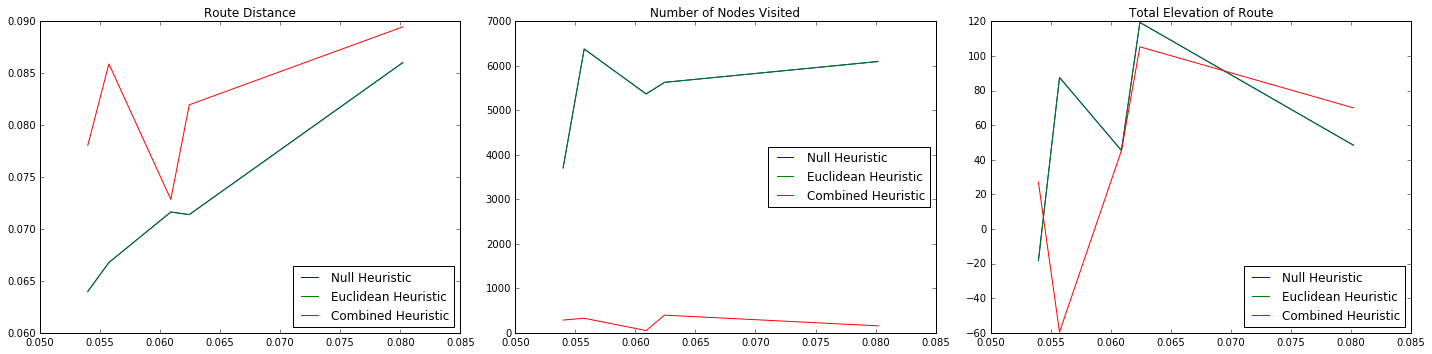

In [29]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

### Safe Road Cost with Elevation

In [31]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
cost_fn = [san_fran_map.get_safe_road_cost_with_elevation,
           san_fran_map.get_safe_road_cost_with_elevation,
           san_fran_map.get_safe_road_cost_with_elevation]
result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

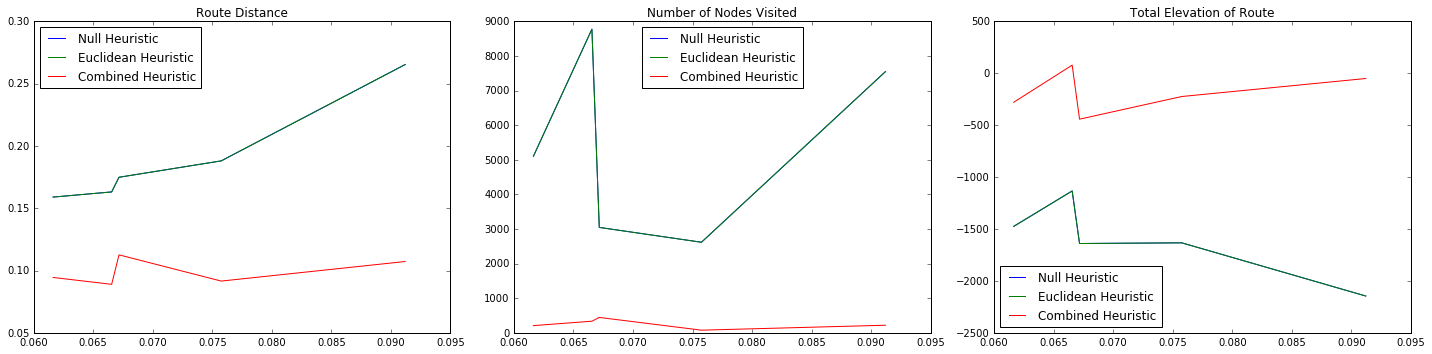

In [32]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

In [54]:
cost_fn = [cambridge_map.get_road_cost, cambridge_map.get_safe_road_cost, cambridge_map.get_safe_road_cost_with_elevation]
heuristic = [cambridge_map.null_heuristic, cambridge_map.null_heuristic, cambridge_map.null_heuristic]

result = execute_simulation(20, cost_fn, heuristic, cambridge_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

<Node> id: 1166, x: -71.117059674, y: 42.3714083431 
Connections: set([u'Plympto_St_4', u'Mt-A_St_5']) <Node> id: 1282, x: -71.1311169815, y: 42.3751929951 
Connections: set([u'Camden_Pl_1'])


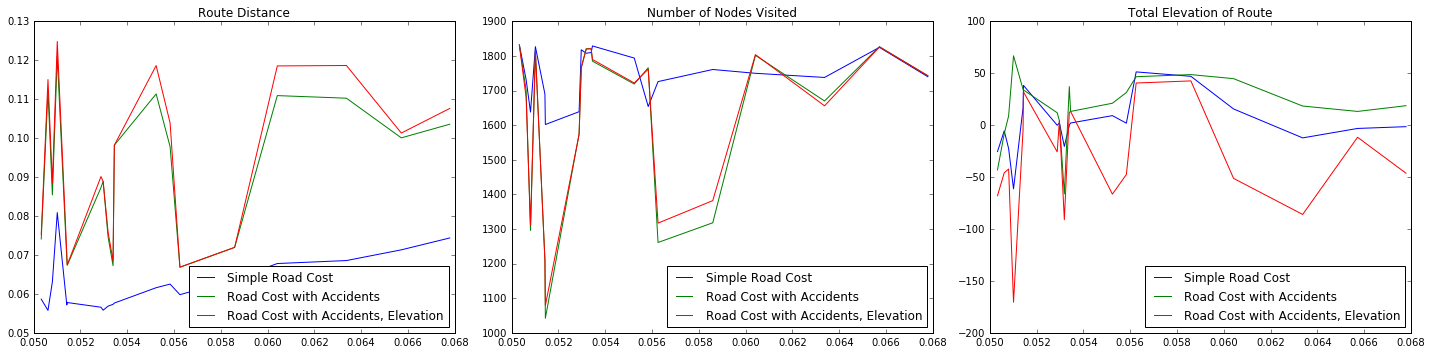

In [55]:
## Compare cost function 
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Simple Road Cost', 'Road Cost with Accidents', 'Road Cost with Accidents, Elevation']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

### Local Search: Simulated Annealing, K-Beam

In [6]:
intersection_graph = cambridge_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

route = cambridge_map.a_star_search(start, end, cambridge_map.get_road_cost, cambridge_map.null_heuristic)

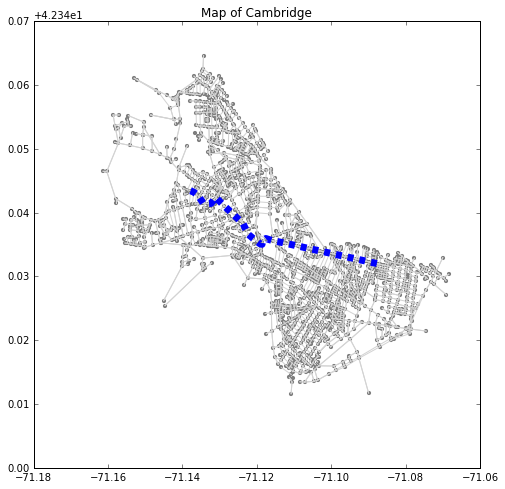

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph([route['nodes']], ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

In [30]:
import time
# define which map type you want to run
test_map = cambridge_map

p1 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p2 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p3 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p4 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
points = [p1,p2,p3,p4]

heuristic_fns = [test_map.null_heuristic, test_map.euclidean_heuristic, test_map.combined_heuristic]
times_annealing = []
times_k_beam = []
costs_annealing = []
costs_k_beam = []

for fn in heuristic_fns:
    # start time annealing
    start = time.clock()
    node_annealing = test_map.simulated_annealing(
                cost_function=test_map.get_road_cost,
                heuristic=fn,
                starting_points=points)
    
    # annealing time
    timer_annealing = time.clock() - start
    times_annealing.append(timer_annealing)
    
    print 'annealing time ', timer_annealing
    
    # annealing costs
    cost = np.sum([test_map.cost(p, node_annealing, test_map.get_road_cost, fn) for p in points])
    costs_annealing.append(cost)
    
    print 'annealing costs ', cost
    
    # start time
    start = time.clock()
    node_k_beam, best_cost, k_points = test_map.k_beam_search(k=5,
                cost_function=test_map.get_road_cost,
                heuristic=fn,
                starting_points=points)
    
    # k beam time
    timer_k_beam = time.clock() - start
    times_k_beam.append(timer_k_beam)
    
    print 'k beam time ', timer_k_beam
    
    # k beam costs
    cost = np.sum([test_map.cost(p, node_k_beam, test_map.get_road_cost, fn) for p in points])
    costs_k_beam.append(cost)
    
    print 'k beam time ', cost
    
# Sorry I am not sure why this is breaking by I am exhausted... :(

annealing time  14.611518
annealing costs  0.0550065336465
iteration  0 best cost 0.0666618132904
iteration  1 best cost 0.0660022111071
iteration  2 best cost 0.0631679443026
iteration  3 best cost 0.0620770422916
iteration  4 best cost 0.0605041402194
iteration  5 best cost 0.0583910468397
iteration  6 best cost 0.0582039048754
iteration  7 best cost 0.0575213646323
iteration  8 best cost 0.054236999931
iteration  9 best cost 0.0525401808994
iteration  10 best cost 0.0522408194229
k beam time  35.574052
k beam time  0.0522408194229
annealing time  2.372772
annealing costs  0.0525401808994
iteration  0 best cost 0.0639321566826
iteration  1 best cost 0.0550010384376
iteration  2 best cost 0.0544496861734
iteration  3 best cost 0.0522408194229
k beam time  2.614653
k beam time  0.0522408194229
annealing time  0.825683
annealing costs  0.0760255054134
iteration  0 best cost 0.0807834947737
iteration  1 best cost 0.0759583944747
iteration  2 best cost 0.0700140525289
iteration  3 best co

([<matplotlib.axis.XTick at 0x124d2c3d0>,
 <a list of 3 Text xticklabel objects>)

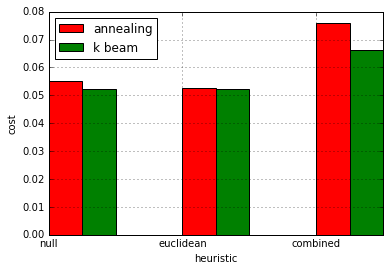

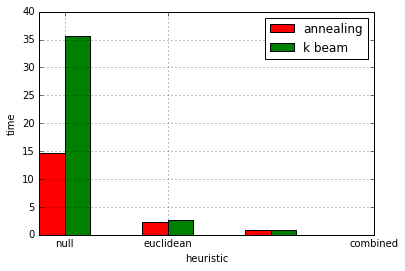

In [52]:
w = 0.25
# fig, ax = plt.subplots(1,1, figsize=(15, 15))
x_ticks = [0,1,2]
plt.bar(x_ticks, costs_annealing, 0.25, color = 'r', label = 'annealing')
plt.bar([x + w for x in x_ticks], costs_k_beam, 0.25, color = 'g', label = 'k beam')
plt.grid(True)
plt.ylabel('cost')
plt.legend(loc='best')
plt.xlabel('heuristic')
plt.xticks([0,1,2], ['null', 'euclidean', 'combined'])
# ax.set_xticklabels(['null', 'euclidean', 'combined'])

plt.figure()
plt.bar(x_ticks, times_annealing, 0.25, color = 'r', label = 'annealing')
plt.bar([x + w for x in x_ticks], times_k_beam, 0.25, color = 'g', label = 'k beam')
plt.grid(True)
plt.ylabel('time')
plt.legend(loc='best')
plt.xlabel('heuristic')
plt.xticks([0+w,1+w,3+w], ['null', 'euclidean', 'combined'])

In [25]:
test_map = cambridge_map

p1 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p2 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p3 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p4 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
points = [p1,p2,p3,p4]

times_k_beam = []
costs_k_beam = []
ks = np.linspace(5,35,10)

# iterate through the beam widths
for k in ks:
    k = int(k)
    start = time.clock()
    
    # run k beam search
    node_k_beam, best_cost, k_points = test_map.k_beam_search(k=k,
                cost_function=test_map.get_safe_road_cost_with_elevation,
                heuristic=test_map.null_heuristic,
                starting_points=points)
    timer = time.clock() - start
    
    # calculate cost
    cost = np.sum([test_map.cost(p, node_k_beam, test_map.get_safe_road_cost_with_elevation, test_map.null_heuristic) for p in points])
    
    # save time and cost
    times_k_beam.append(timer)
    costs_k_beam.append(cost)
# same comment here

iteration  0 best cost 661.824327247
iteration  1 best cost 656.116166625
iteration  2 best cost 648.812362056
iteration  0 best cost 765.954846906
iteration  1 best cost 717.570763721
iteration  2 best cost 699.53814182
iteration  3 best cost 652.594570809
iteration  4 best cost 639.225943006
iteration  5 best cost 617.851632915
iteration  0 best cost 611.766619157
iteration  0 best cost 611.766619157
iteration  0 best cost 639.944556741
iteration  0 best cost 639.944556741
iteration  1 best cost 611.766619157
iteration  0 best cost 661.824327247
iteration  1 best cost 651.548825402
iteration  2 best cost 648.812362056
iteration  3 best cost 639.225943006
iteration  4 best cost 617.851632915
iteration  0 best cost 620.329445757
iteration  1 best cost 611.766619157
iteration  0 best cost 650.177911334
iteration  1 best cost 639.225943006
iteration  2 best cost 617.851632915
iteration  0 best cost 611.766619157


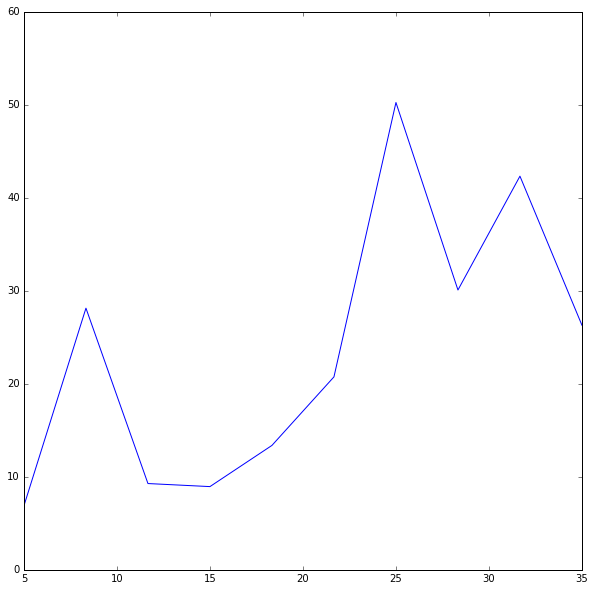

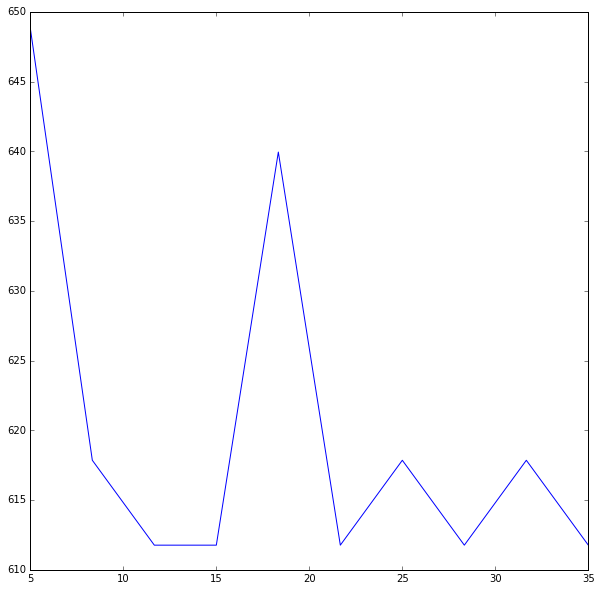

In [27]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(5,35,10), times_k_beam)
plt.figure(figsize=(10,10))
plt.plot(np.linspace(5,35,10), costs_k_beam)